# Beyond linear separation in classification

As we saw in the regression section, the linear classification model
expects the data to be linearly separable. When this assumption does not
hold, the model is not expressive enough to properly fit the data.
Therefore, we need to apply the same tricks as in regression: feature
augmentation (potentially using expert-knowledge) or using a
kernel-based method.

We will provide examples where we will use a kernel support vector machine
to perform classification on some toy-datasets where it is impossible to
find a perfect linear separation.

First, we redefine our plotting utility to show the decision boundary of a
classifier.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


def plot_decision_function(fitted_classifier, range_features, ax=None):
    """Plot the boundary of the decision function of a classifier."""
    from sklearn.preprocessing import LabelEncoder

    feature_names = list(range_features.keys())
    # create a grid to evaluate all possible samples
    plot_step = 0.02
    xx, yy = np.meshgrid(
        np.arange(*range_features[feature_names[0]], plot_step),
        np.arange(*range_features[feature_names[1]], plot_step),
    )

    # compute the associated prediction
    Z = fitted_classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = LabelEncoder().fit_transform(Z)
    Z = Z.reshape(xx.shape)

    # make the plot of the boundary and the data samples
    if ax is None:
        _, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.4, cmap="RdBu")

    return ax

We will generate a first dataset where the data are represented as two
interlaced half circle. This dataset is generated using the function
[`sklearn.datasets.make_moons`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html).

In [2]:
import pandas as pd
from sklearn.datasets import make_moons

feature_names = ["Feature #0", "Features #1"]
target_name = "class"

X, y = make_moons(n_samples=100, noise=0.13, random_state=42)

# We store both the data and target in a dataframe to ease plotting
moons = pd.DataFrame(np.concatenate([X, y[:, np.newaxis]], axis=1),
                     columns=feature_names + [target_name])
data_moons, target_moons = moons[feature_names], moons[target_name]

range_features_moons = {"Feature #0": (-2, 2.5), "Feature #1": (-2, 2)}

Since the dataset contains only two features, we can make a scatter plot to
have a look at it.

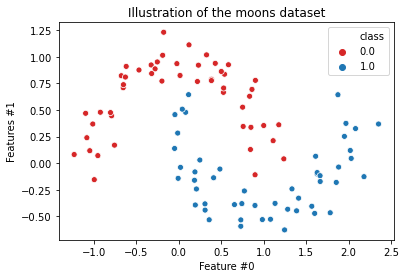

In [3]:
import seaborn as sns

sns.scatterplot(data=moons, x=feature_names[0], y=feature_names[1],
                hue=target_moons, palette=["tab:red", "tab:blue"])
_ = plt.title("Illustration of the moons dataset")

From the intuitions that we got by studying linear model, it should be
obvious that a linear classifier will not be able to find a perfect decision
function to separate the two classes.

Let's try to see what is the decision boundary of such a linear classifier.
We will create a predictive model by standardizing the dataset followed by
a linear support vector machine classifier.

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

linear_model = make_pipeline(StandardScaler(), SVC(kernel="linear"))
linear_model.fit(data_moons, target_moons)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear'))])

<div class="admonition warning alert alert-danger">
<p class="first admonition-title" style="font-weight: bold;">Warning</p>
<p class="last">Be aware that we fit and will check the boundary decision of the classifier
on the same dataset without splitting the dataset into a training set and a
testing set. While this is a bad practice, we use it for the sake of
simplicity to depict the model behavior. Always use cross-validation when
you want to assess the statistical performance of a machine-learning model.</p>
</div>

Let's check the decision boundary of such a linear model on this dataset.

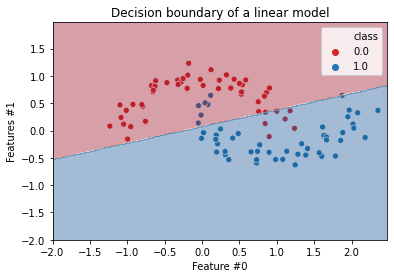

In [5]:
ax = sns.scatterplot(data=moons, x=feature_names[0], y=feature_names[1],
                     hue=target_moons, palette=["tab:red", "tab:blue"])
plot_decision_function(linear_model, range_features_moons, ax=ax)
_ = plt.title("Decision boundary of a linear model")

As expected, a linear decision boundary is not enough flexible to split the
two classes.

To push this example to the limit, we will create another dataset where
samples of a class will be surrounded by samples from the other class.

In [6]:
from sklearn.datasets import make_gaussian_quantiles

feature_names = ["Feature #0", "Features #1"]
target_name = "class"

X, y = make_gaussian_quantiles(
    n_samples=100, n_features=2, n_classes=2, random_state=42)
gauss = pd.DataFrame(np.concatenate([X, y[:, np.newaxis]], axis=1),
                     columns=feature_names + [target_name])
data_gauss, target_gauss = gauss[feature_names], gauss[target_name]

range_features_gauss = {"Feature #0": (-4, 4), "Feature #1": (-4, 4)}

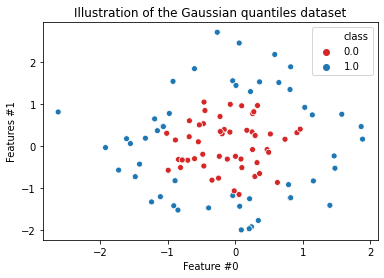

In [7]:
ax = sns.scatterplot(data=gauss, x=feature_names[0], y=feature_names[1],
                     hue=target_gauss, palette=["tab:red", "tab:blue"])
_ = plt.title("Illustration of the Gaussian quantiles dataset")

Here, this is even more obvious that a linear decision function is not
adapted. We can check what decision function, a linear support vector machine
will find.

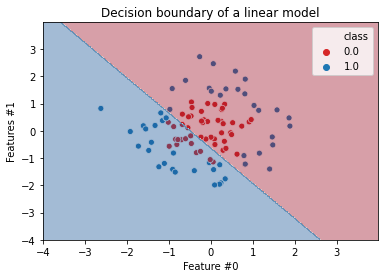

In [8]:
linear_model.fit(data_gauss, target_gauss)
ax = sns.scatterplot(data=gauss, x=feature_names[0], y=feature_names[1],
                     hue=target_gauss, palette=["tab:red", "tab:blue"])
plot_decision_function(linear_model, range_features_gauss, ax=ax)
_ = plt.title("Decision boundary of a linear model")

As expected, a linear separation cannot be used to separate the classes
properly: the model will under-fit as it will make errors even on
the training set.

In the section about linear regression, we saw that we could use several
tricks to make a linear model more flexible by augmenting features or
using a kernel. Here, we will use the later solution by using a radial basis
function (RBF) kernel together with a support vector machine classifier.

We will repeat the two previous experiments and check the obtained decision
function.

In [9]:
kernel_model = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma=5))

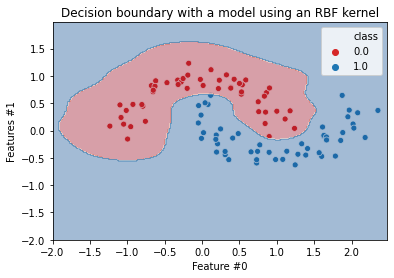

In [10]:
kernel_model.fit(data_moons, target_moons)
ax = sns.scatterplot(data=moons, x=feature_names[0], y=feature_names[1],
                     hue=target_moons, palette=["tab:red", "tab:blue"])
plot_decision_function(kernel_model, range_features_moons, ax=ax)
_ = plt.title("Decision boundary with a model using an RBF kernel")

We see that the decision boundary is not anymore a straight line. Indeed,
an area is defined around the red samples and we could imagine that this
classifier should be able to generalize on unseen data.

Let's check the decision function on the second dataset.

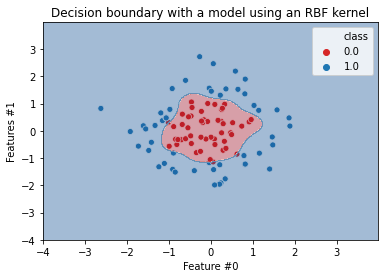

In [11]:
kernel_model.fit(data_gauss, target_gauss)
ax = sns.scatterplot(data=gauss, x=feature_names[0], y=feature_names[1],
                     hue=target_gauss, palette=["tab:red", "tab:blue"])
plot_decision_function(kernel_model, range_features_gauss, ax=ax)
_ = plt.title("Decision boundary with a model using an RBF kernel")

We observe something similar than in the previous case. The decision function
is more flexible and does not underfit anymore.

Thus, kernel trick or feature expansion are the tricks to make a linear
classifier more expressive, exactly as we saw in regression.

Keep in mind that adding flexibility to a model can also risk increasing
overfitting by making the decision function to sensitive to individual
(possibly noisy) data points of the training set. Here we can observe that
the decision functions remain smooth enough to preserve good generalization.
If you are curious, you can try repeated the above experiment with
`gamma=100` and look at the decision functions.